### Add scripts path to the notebook

In [1]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 3\ACIS-Car-Insurance-Claim-Analysis\notebooks


### Import Statements

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Load the data

In [3]:
PATH_TO_DATA = "../data/MachineLearningRating_v3.txt"

In [4]:
data = pd.read_csv(filepath_or_buffer=PATH_TO_DATA, delimiter='|', low_memory=False)

### Data Cleaning

1) Find missing values

In [5]:
# find columns with na values
column_na_rations = data.isna().mean()

# print out columns that have missing values and the amount of missing values as percentages
column_na_rations[column_na_rations > 0].sort_values(ascending=False) * 100

NumberOfVehiclesInFleet    100.000000
CrossBorder                 99.930207
CustomValueEstimate         77.956560
WrittenOff                  64.183810
Converted                   64.183810
Rebuilt                     64.183810
NewVehicle                  15.327998
Bank                        14.594670
AccountType                  4.022806
Gender                       0.953507
MaritalStatus                0.825819
mmcode                       0.055195
VehicleType                  0.055195
make                         0.055195
VehicleIntroDate             0.055195
NumberOfDoors                0.055195
bodytype                     0.055195
kilowatts                    0.055195
cubiccapacity                0.055195
Cylinders                    0.055195
Model                        0.055195
CapitalOutstanding           0.000200
dtype: float64

2) Handle missing values

- drop columns with a lot of missing values, i.e greater than 50%

In [6]:
# find the columns with missing values greater than 50%
to_be_droped = column_na_rations[column_na_rations > 0.5].keys()

# drop the columns
data = data.drop(columns=to_be_droped)

- removes data for column with missing values less than 5%

In [7]:
# find the columns with missing values less than 5%
to_be_droped = column_na_rations[column_na_rations < 0.05].keys()

# drop the columns
data = data.dropna(subset=to_be_droped)

- For columns in between use mode or mean(depending on column data type) to replace the missing values

In [8]:
# find the columns with missing values greater than 5% and less than 50%
to_be_replaced = column_na_rations[(column_na_rations >= 0.05) & (column_na_rations <=0.5)].keys()

Find the data type of those columns

In [9]:
data[[*to_be_replaced]].dtypes

Bank          object
NewVehicle    object
dtype: object

Both are categorical so I will use their respective modes

In [10]:
for column in to_be_replaced:
    # Get the mode of the column
    mode_value = data[column].mode()[0]  
    # Fill missing values with the mode
    data[column] = data[column].fillna(mode_value)  

Finally check for the missing values

In [11]:
# find columns with na values
column_na_rations = data.isna().mean()

# print out columns that have missing values and the amount of missing values as percentages
column_na_rations[column_na_rations > 0].sort_values(ascending=False) * 100

Series([], dtype: float64)

### Feature Engineering

1) I wanted to calculate the optimal premium values for every customer based on their TotalClaims. As this is a business money needs to be made and hence the premium price should at least give a return of 0, break even. So I will create a new feature , from TotalClaims and TotalPremium, called OptimumPremium.

In [12]:
# if the difference between totalPremium and totalClaims is negative then set the optimum premim = totalPremium + (TotalClaims - TotalPremium) else just make it equal to total premium
data['OptimalPremium'] = data['TotalPremium'] + np.minimum(0, data['TotalPremium'] - data['TotalClaims']) * -1

Check the result of the top 10 rows

In [13]:
data[['TotalClaims', 'TotalPremium', 'OptimalPremium']].sort_values(by='TotalClaims' , ascending=False).head(10)

,TotalClaims,TotalPremium,OptimalPremium
451249,393092.105263,243.538333,393092.105263
601844,376432.491228,562.617807,376432.491228
818316,363343.421053,1065.027982,363343.421053
173451,304338.657895,818.206140,304338.657895
172766,302361.149123,825.392281,302361.149123
402798,286686.431053,783.867018,286686.431053
803349,269311.929825,806.181579,269311.929825
904510,265789.473684,1060.473070,265789.473684
920077,263157.632807,857.887193,263157.632807
710484,261307.017544,1261.964035,261307.017544


2) Encode categorical values from the user information

In [14]:
# columns of car feature
car_features = ['Cylinders', 'NewVehicle', 'RegistrationYear', 'VehicleType', 'NumberOfDoors', 'kilowatts']

# columns of user location
location_features = ['Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone']

# columns of user information
user_features = ['Gender', 'MaritalStatus', 'AccountType', 'Citizenship']

# target columns
target_col = ['OptimalPremium']

# predictor columns
predict_col = [*car_features, *location_features, *user_features]

# combine features
all_features = [*car_features, *location_features, *user_features, *target_col]

In [15]:
# find categorical features
data_types = data[all_features].dtypes

categorical = []
numerical = []
for idx, dtype in enumerate(data_types):
    if dtype == object:
        categorical.append(all_features[idx])
    else:
        numerical.append(all_features[idx])

Now encode the features

In [16]:
new_df = pd.DataFrame()

In [17]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical feature
for col in categorical:
    # Apply LabelEncoder to each categorical column
    new_df[col] = label_encoder.fit_transform(data[col])

In [18]:
new_df[numerical] = data[numerical]

In [19]:
new_df = new_df.dropna()

### Split the data

In [20]:
# get feature data
X = new_df[predict_col]

# get target data
y = new_df[target_col]

Split the data 80-20

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=.2)

### Train models

In [22]:
from scripts.training import train_and_log_model, initialize_mlflow, explain_model_with_shap

d:\KifiyaAIM-Course\Week - 3\ACIS-Car-Insurance-Claim-Analysis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1) Initialize mlflow tracking uri

In [23]:
tracking_uri = "notebook"
experiment_name = "Optimum Price"
tracking_id = initialize_mlflow(uri=tracking_uri, experiment_name=experiment_name)

2) Train the models

In [24]:
# Models to train
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
}

In [25]:
# Store the best model
best_model = None
best_r2 = -float('inf')  # Initialize as negative infinity
best_mse = float('inf')  # Initialize MSE as positive infinity

In [26]:
# Train each model and log with MLflow
for model_name, model in models.items():
    print(f"Training {model_name}...")
    mse, r2, trained_model = train_and_log_model(model, model_name,tracking_id, x_train, y_train, x_test, y_test)
    
    # Compare based on r2 score (or you can change to mse)
    if r2 > best_r2:
        best_r2 = r2
        best_mse = mse
        best_model = trained_model

Training LinearRegression...


2024/09/19 19:49:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training RandomForestRegressor...


2024/09/19 19:54:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training GradientBoostingRegressor...


2024/09/19 19:56:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training DecisionTreeRegressor...


2024/09/19 19:56:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [27]:
# Print out the best model's results
print(f"Best model: {best_model.__class__.__name__}")
print(f"Best R2 Score: {best_r2}")
print(f"Best MSE: {best_mse}")

Best model: LinearRegression
Best R2 Score: 6.089087107241653e-05
Best MSE: 4968395.428208677


### Explain the model

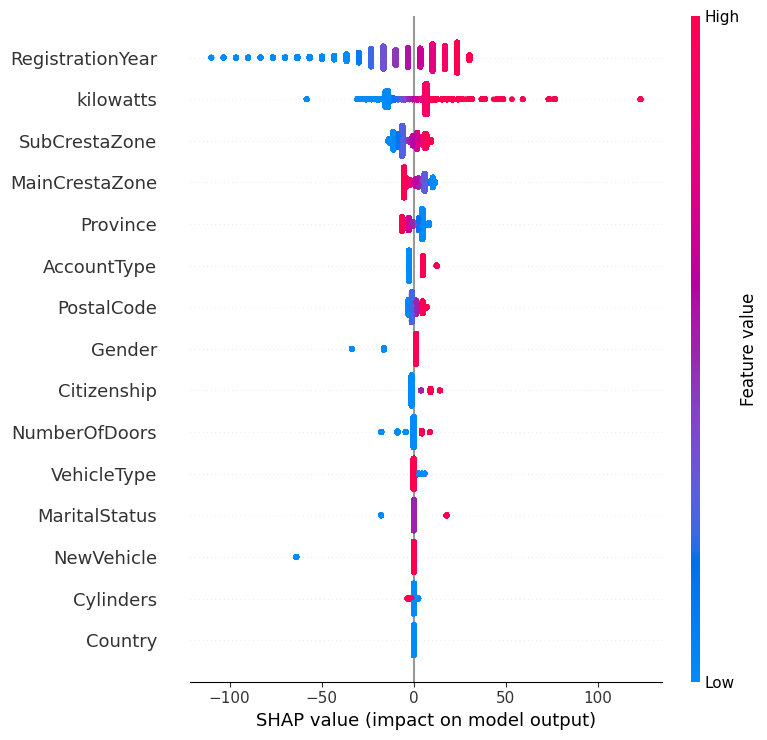

In [28]:
# Generate SHAP explanations for the best model
shap_values = explain_model_with_shap(best_model, x_train, x_test)

#### Visual Interpretation

- Y-Axis (Features): Lists the features used in the model, such as RegistrationYear, kilowatts, MainCrestaZone, SubCrestaZone, Province, AccountType, PostalCode, Citizenship, Gender, NumberOfDoors, VehicleType, MaritalStatus, NewVehicle, Cylinders, and Country.
- X-Axis (SHAP Value): Represents the impact of each feature on the model’s output. The values range from approximately -100 to 100.

    *  Positive SHAP Values (bars extending to the right): Indicate that higher values of the feature increase the model’s prediction.
    *  Negative SHAP Values (bars extending to the left): Indicate that higher values of the feature decrease the model’s prediction.
    *  Color Gradient: The color of the bars ranges from blue (low feature value) to red (high feature value), showing the magnitude of the feature’s value.

#### Result Insights
- RegistrationYear and kilowatts have significant impacts on the model’s predictions, with both positive and negative SHAP values.
- MainCrestaZone and SubCrestaZone also show notable impacts, suggesting these features are important for the model.
- Features like Province, AccountType, and PostalCode have moderate impacts.
- Gender, Citizenship, and NumberOfDoors have smaller impacts compared to other features.